In [36]:
import matplotlib.pyplot as plt
import numpy as np
import tqdm
# set plot size to fill the width of the page
plt.rcParams["figure.figsize"] = (10, 5)
import copy

# Model definition

In [10]:
# simple multi_layer perceptron with relu nonlinearity with pytorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class Net(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Net, self).__init__()
        self.input_size = input_size
        self.hidden_size  = hidden_size
        self.output_size = output_size
        self.fc1 = nn.Linear(self.input_size, self.hidden_size)
        self.fc2 = nn.Linear(self.hidden_size, self.hidden_size)
        self.fc3 = nn.Linear(self.hidden_size, self.output_size)
        self.relu1 = nn.LeakyReLU(negative_slope=nn.Parameter(torch.tensor(0), requires_grad=False), inplace=True)
        self.relu2 = nn.LeakyReLU(negative_slope=nn.Parameter(torch.tensor(0), requires_grad=False), inplace=True)

    def forward(self, x):
        x = self.fc1(x)
        # x = self.relu1(x)
        # x = self.fc2(x)
        x = self.relu2(x)
        x = self.fc3(x)            
        return x

In [23]:
model = Net(1, 500, 1)

In [24]:
model

Net(
  (fc1): Linear(in_features=1, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=500, bias=True)
  (fc3): Linear(in_features=500, out_features=1, bias=True)
  (relu1): LeakyReLU(
    negative_slope=Parameter containing:
    tensor(0), inplace=True
  )
  (relu2): LeakyReLU(
    negative_slope=Parameter containing:
    tensor(0), inplace=True
  )
)

# Sample dataset

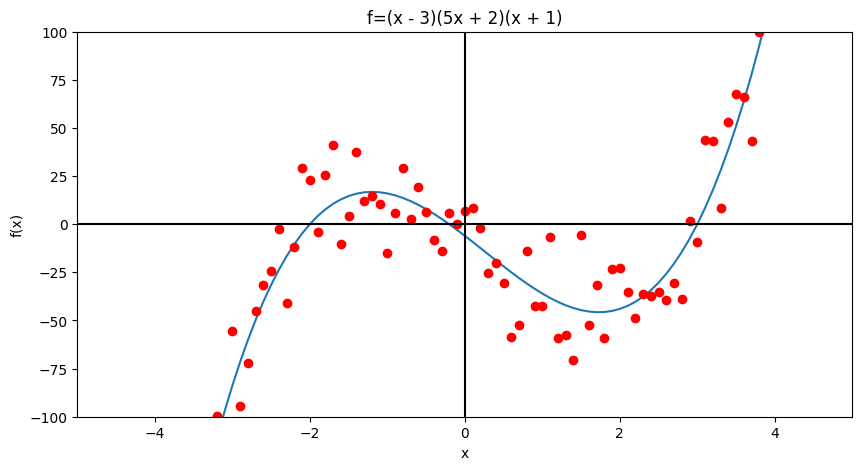

In [25]:
# plot function f=(x - 3)*(x + 2)*(x + 1)
x = np.arange(-5, 5, 0.1)
noise = np.random.normal(0, 15, x.shape)
y = (x - 3)*(x + 2)*(5*x + 1)
plt.plot(x, y)
plt.plot(x, y + noise, 'ro')
plt.xlabel('x')
plt.ylabel('f(x)')
plt.xlim(-5, 5)
plt.ylim(-100, 100)
# baseline
plt.axhline(y=0, color='k')
plt.axvline(x=0, color='k')
plt.title('f=(x - 3)(5x + 2)(x + 1)')
plt.show()


In [26]:
# train model on x and y + noise
# convert to torch tensors
# broadcast x to 100 x 1 tensor

X = torch.from_numpy(x.reshape(-1,1)).float()
Y = torch.from_numpy((y + noise).reshape(-1,1)).float()

print(X.shape)
# define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)
wd = 0.000

losses = []

# train model
for epoch in tqdm.tqdm(range(10000)):
    # forward pass
    y_pred = model(X)
    # compute loss
    loss = criterion(y_pred, Y) + (torch.norm(model.fc1.weight, 1) + torch.norm(model.fc2.weight, 1) + torch.norm(model.fc3.weight, 1)) * wd
    # zero gradients
    optimizer.zero_grad()
    # backward pass
    loss.backward()
    losses.append(loss.item())
    # update weights
    optimizer.step()
    if epoch % 1000 == 0:
        tqdm.tqdm.write('epoch {}, loss {}'.format(epoch, loss.item()))

torch.Size([100, 1])


  1%|          | 88/10000 [00:00<00:11, 876.66it/s]

epoch 0, loss 28095.23828125


 12%|█▏        | 1161/10000 [00:01<00:08, 1081.69it/s]

epoch 1000, loss 300.65655517578125


 22%|██▏       | 2157/10000 [00:02<00:07, 1087.09it/s]

epoch 2000, loss 254.34104919433594


 32%|███▏      | 3171/10000 [00:02<00:06, 1112.62it/s]

epoch 3000, loss 236.00502014160156


 42%|████▏     | 4174/10000 [00:03<00:05, 1087.84it/s]

epoch 4000, loss 224.6740264892578


 52%|█████▏    | 5175/10000 [00:04<00:04, 1083.31it/s]

epoch 5000, loss 218.18267822265625


 62%|██████▏   | 6173/10000 [00:05<00:03, 1091.59it/s]

epoch 6000, loss 214.34152221679688


 72%|███████▏  | 7181/10000 [00:06<00:02, 1095.38it/s]

epoch 7000, loss 211.33099365234375


 82%|████████▏ | 8189/10000 [00:07<00:01, 1103.47it/s]

epoch 8000, loss 209.24879455566406


 92%|█████████▏| 9195/10000 [00:08<00:00, 1097.60it/s]

epoch 9000, loss 207.68092346191406


100%|██████████| 10000/10000 [00:09<00:00, 1094.81it/s]


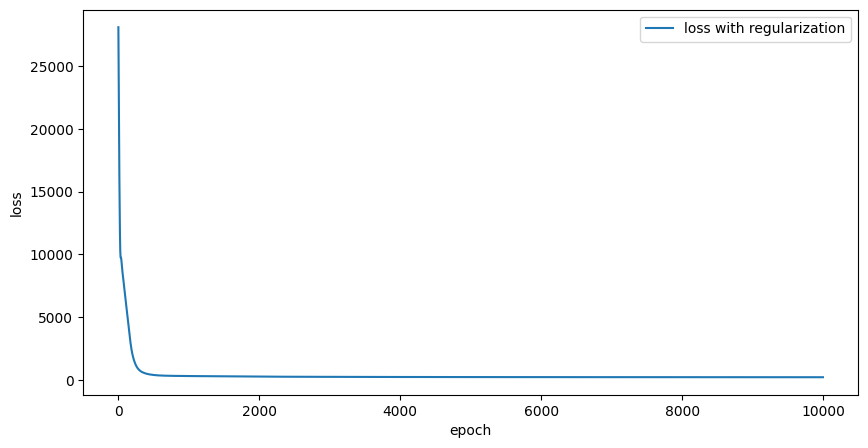

In [27]:
# plot loss
plt.plot(losses, label='loss with regularization')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

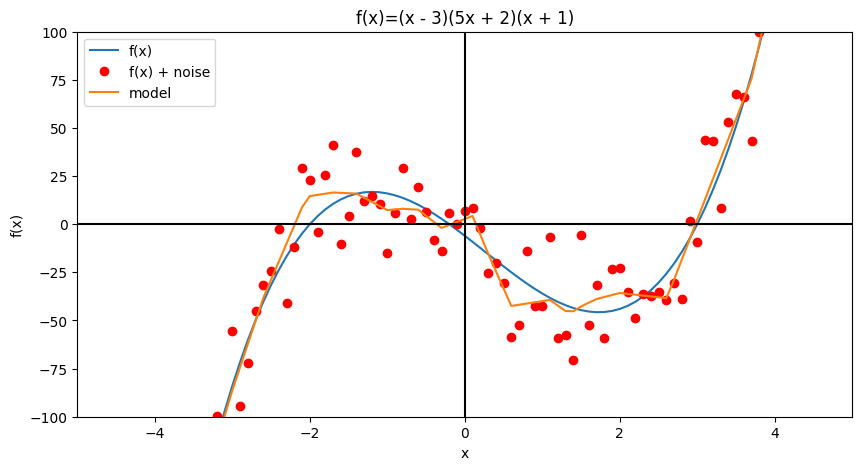

In [28]:
#plot model predictions
plt.plot(x, y, label='f(x)')
plt.plot(x, y + noise, 'ro', label='f(x) + noise')
plt.plot(x, model(X).detach().numpy(), label='model')
plt.xlabel('x')
plt.ylabel('f(x)')
plt.xlim(-5, 5)
plt.ylim(-100, 100)
# baseline
plt.axhline(y=0, color='k')
plt.axvline(x=0, color='k')
plt.title('f(x)=(x - 3)(5x + 2)(x + 1)')
plt.legend()
plt.show()

# change model relu slope to 0.5 without finetuning

In [53]:
collapsed_model = copy.deepcopy(model)

In [54]:
# model.backbone.classifier._modules[_number] = new_module
collapsed_model._modules['relu2'] = nn.LeakyReLU(negative_slope=nn.Parameter(torch.tensor(0.5), requires_grad=False), inplace=True)

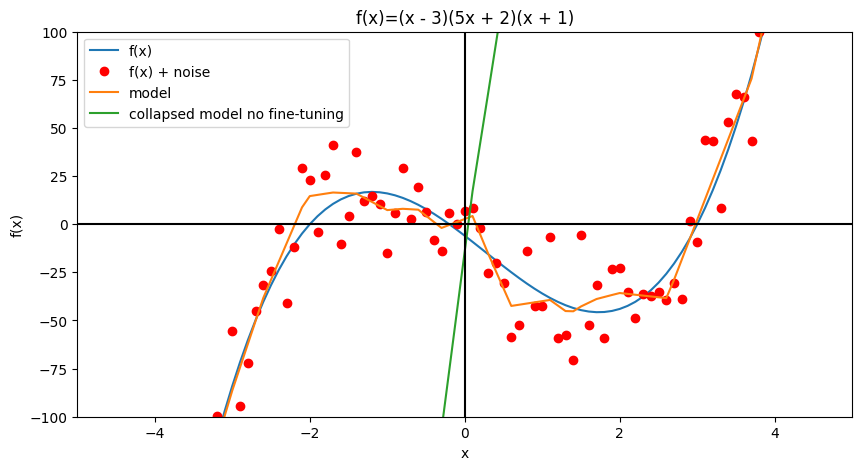

In [55]:
#plot model predictions
plt.plot(x, y, label='f(x)')
plt.plot(x, y + noise, 'ro', label='f(x) + noise')
plt.plot(x, model(X).detach().numpy(), label='model')
plt.plot(x, collapsed_model(X).detach().numpy(), label='collapsed model no fine-tuning')
plt.xlabel('x')
plt.ylabel('f(x)')
plt.xlim(-5, 5)
plt.ylim(-100, 100)
# baseline
plt.axhline(y=0, color='k')
plt.axvline(x=0, color='k')
plt.title('f(x)=(x - 3)(5x + 2)(x + 1)')
plt.legend()
plt.show()

 23%|██▎       | 228/1000 [00:00<00:00, 1141.79it/s]

epoch 0, loss 654492.9375


100%|██████████| 1000/1000 [00:00<00:00, 1172.13it/s]


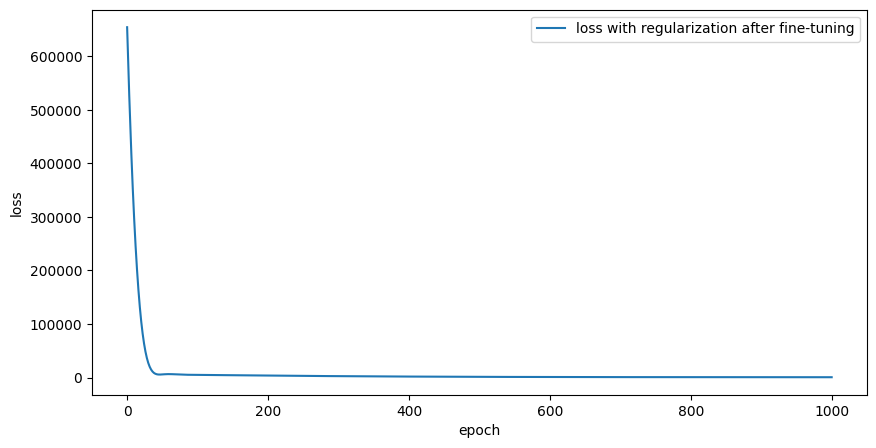

In [56]:
# finetuen collapsed model
# define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(collapsed_model.parameters(), lr=0.01)
wd = 0.000

losses_finetune = []

# train model
for epoch in tqdm.tqdm(range(1000)):
    # forward pass
    y_pred = collapsed_model(X)
    # compute loss
    loss = criterion(y_pred, Y) + (torch.norm(collapsed_model.fc1.weight, 1) + torch.norm(collapsed_model.fc2.weight, 1) + torch.norm(collapsed_model.fc3.weight, 1)) * wd
    # zero gradients
    optimizer.zero_grad()
    # backward pass
    loss.backward()
    losses_finetune.append(loss.item())
    # update weights
    optimizer.step()
    if epoch % 1000 == 0:
        tqdm.tqdm.write('epoch {}, loss {}'.format(epoch, loss.item()))

# plot loss
plt.plot(losses_finetune, label='loss with regularization after fine-tuning')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

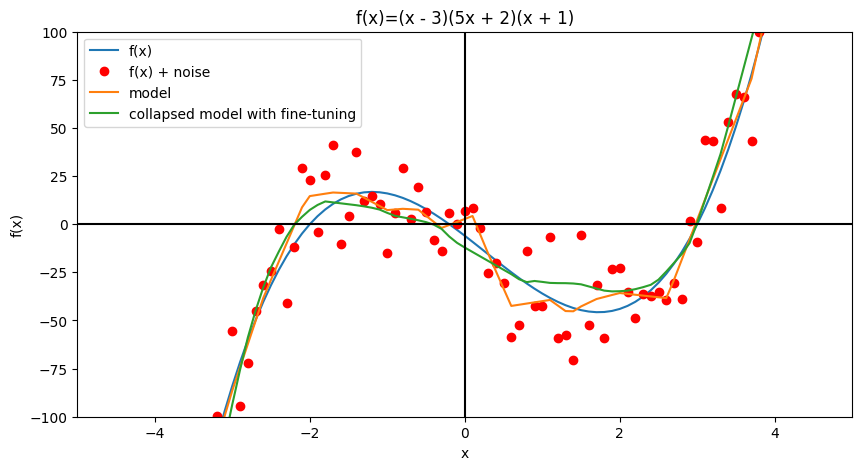

In [57]:
#plot model predictions
plt.plot(x, y, label='f(x)')
plt.plot(x, y + noise, 'ro', label='f(x) + noise')
plt.plot(x, model(X).detach().numpy(), label='model')
plt.plot(x, collapsed_model(X).detach().numpy(), label='collapsed model with fine-tuning')
plt.xlabel('x')
plt.ylabel('f(x)')
plt.xlim(-5, 5)
plt.ylim(-100, 100)
# baseline
plt.axhline(y=0, color='k')
plt.axvline(x=0, color='k')
plt.title('f(x)=(x - 3)(5x + 2)(x + 1)')
plt.legend()
plt.show()

In [72]:
almost_fully_collapsed_model = copy.deepcopy(model)
almost_fully_collapsed_model._modules['relu2'] = nn.LeakyReLU(negative_slope=nn.Parameter(torch.tensor(.8), requires_grad=False), inplace=True)

  5%|▍         | 230/5000 [00:00<00:04, 1153.94it/s]

epoch 0, loss 1675217.0


 24%|██▎       | 1184/5000 [00:01<00:03, 1168.89it/s]

epoch 1000, loss 5081.5546875


 43%|████▎     | 2133/5000 [00:01<00:02, 1171.96it/s]

epoch 2000, loss 3094.5615234375


 64%|██████▍   | 3202/5000 [00:02<00:01, 1174.79it/s]

epoch 3000, loss 1542.03759765625


 83%|████████▎ | 4153/5000 [00:03<00:00, 1177.66it/s]

epoch 4000, loss 738.1572875976562


100%|██████████| 5000/5000 [00:04<00:00, 1177.88it/s]


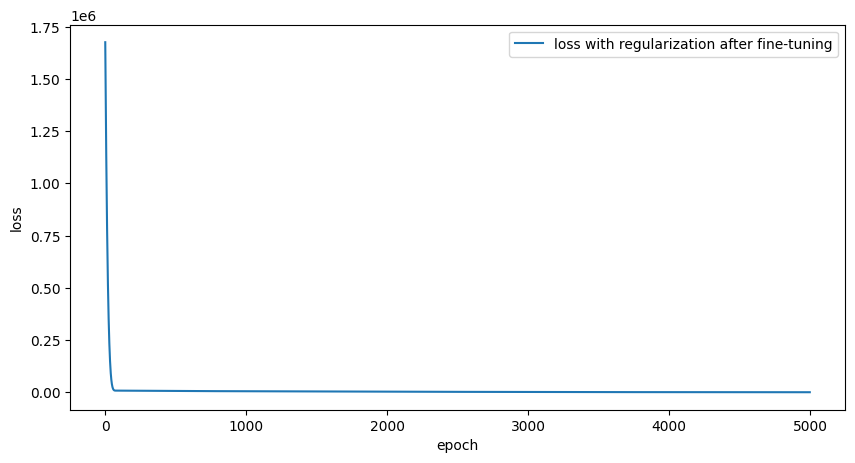

In [73]:
# finetuen collapsed model
# define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(almost_fully_collapsed_model.parameters(), lr=0.01)
wd = 0.000

losses_finetune = []

# train model
for epoch in tqdm.tqdm(range(5000)):
    # forward pass
    y_pred = almost_fully_collapsed_model(X)
    # compute loss
    loss = criterion(y_pred, Y) + (torch.norm(almost_fully_collapsed_model.fc1.weight, 1) + torch.norm(almost_fully_collapsed_model.fc2.weight, 1) + torch.norm(almost_fully_collapsed_model.fc3.weight, 1)) * wd
    # zero gradients
    optimizer.zero_grad()
    # backward pass
    loss.backward()
    losses_finetune.append(loss.item())
    # update weights
    optimizer.step()
    if epoch % 1000 == 0:
        tqdm.tqdm.write('epoch {}, loss {}'.format(epoch, loss.item()))

# plot loss
plt.plot(losses_finetune, label='loss with regularization after fine-tuning')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

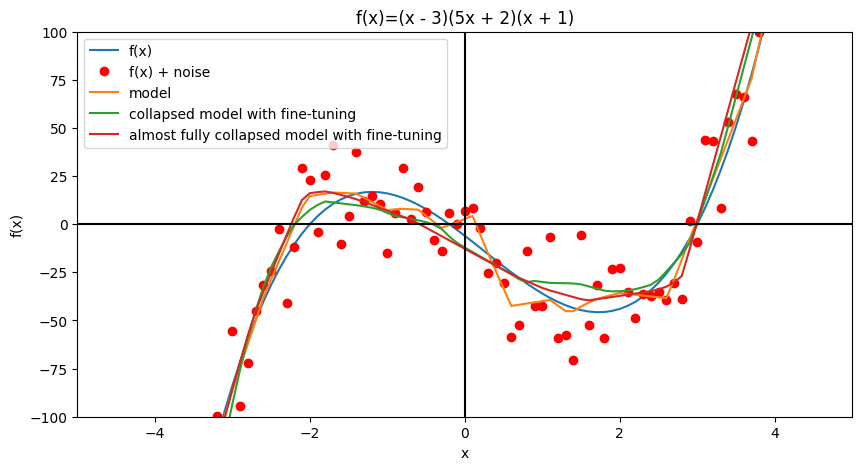

In [74]:
#plot model predictions
plt.plot(x, y, label='f(x)')
plt.plot(x, y + noise, 'ro', label='f(x) + noise')
plt.plot(x, model(X).detach().numpy(), label='model')
plt.plot(x, collapsed_model(X).detach().numpy(), label='collapsed model with fine-tuning')
plt.plot(x, almost_fully_collapsed_model(X).detach().numpy(), label='almost fully collapsed model with fine-tuning')
plt.xlabel('x')
plt.ylabel('f(x)')
plt.xlim(-5, 5)
plt.ylim(-100, 100)
# baseline
plt.axhline(y=0, color='k')
plt.axvline(x=0, color='k')
plt.title('f(x)=(x - 3)(5x + 2)(x + 1)')
plt.legend()
plt.show()

In [88]:
fully_collapsed_model = copy.deepcopy(almost_fully_collapsed_model)
fully_collapsed_model._modules['relu2'] = nn.LeakyReLU(negative_slope=nn.Parameter(torch.tensor(0.99), requires_grad=False), inplace=True)

  2%|▏         | 224/10000 [00:00<00:08, 1127.39it/s]

epoch 0, loss 6429.4111328125


 12%|█▏        | 1159/10000 [00:01<00:07, 1157.32it/s]

epoch 1000, loss 6227.07421875


 22%|██▏       | 2208/10000 [00:01<00:06, 1158.67it/s]

epoch 2000, loss 5991.46728515625


 32%|███▏      | 3165/10000 [00:02<00:05, 1181.03it/s]

epoch 3000, loss 5769.66259765625


 42%|████▏     | 4220/10000 [00:03<00:04, 1156.42it/s]

epoch 4000, loss 5560.078125


 52%|█████▏    | 5156/10000 [00:04<00:04, 1162.68it/s]

epoch 5000, loss 5365.52197265625


 62%|██████▏   | 6229/10000 [00:05<00:03, 1166.47it/s]

epoch 6000, loss 5181.04541015625


 72%|███████▏  | 7163/10000 [00:06<00:02, 1157.59it/s]

epoch 7000, loss 5005.244140625


 82%|████████▏ | 8210/10000 [00:07<00:01, 1149.74it/s]

epoch 8000, loss 4885.14990234375


 91%|█████████▏| 9142/10000 [00:07<00:00, 1141.99it/s]

epoch 9000, loss 4685.84423828125


100%|██████████| 10000/10000 [00:08<00:00, 1162.70it/s]


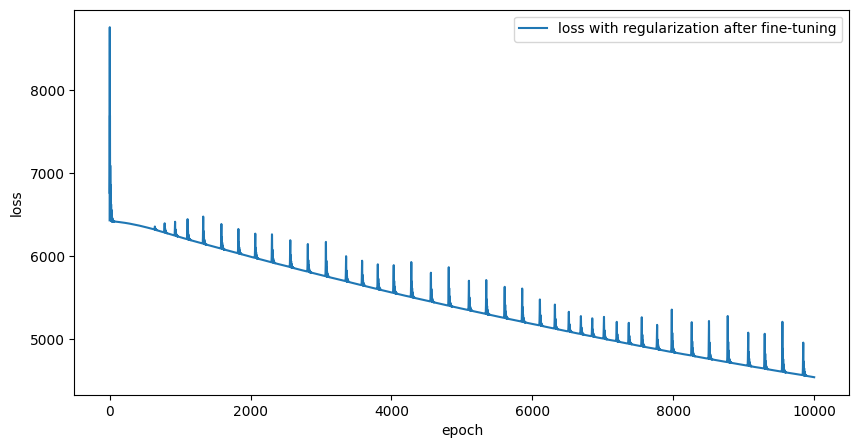

In [91]:
# finetuen collapsed model
# define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(fully_collapsed_model.parameters(), lr=0.01)
wd = 0.000

losses_finetune = []

# train model
for epoch in tqdm.tqdm(range(10000)):
    # forward pass
    y_pred = fully_collapsed_model(X)
    # compute loss
    loss = criterion(y_pred, Y) + (torch.norm(fully_collapsed_model.fc1.weight, 1) + torch.norm(fully_collapsed_model.fc2.weight, 1) + torch.norm(fully_collapsed_model.fc3.weight, 1)) * wd
    # zero gradients
    optimizer.zero_grad()
    # backward pass
    loss.backward()
    losses_finetune.append(loss.item())
    # update weights
    optimizer.step()
    if epoch % 1000 == 0:
        tqdm.tqdm.write('epoch {}, loss {}'.format(epoch, loss.item()))

# plot loss
plt.plot(losses_finetune, label='loss with regularization after fine-tuning')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

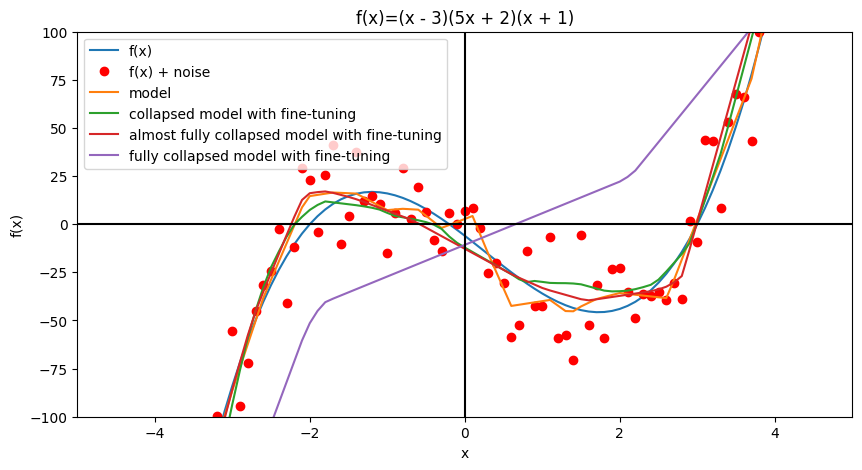

In [92]:
#plot model predictions
plt.plot(x, y, label='f(x)')
plt.plot(x, y + noise, 'ro', label='f(x) + noise')
plt.plot(x, model(X).detach().numpy(), label='model')
plt.plot(x, collapsed_model(X).detach().numpy(), label='collapsed 50% model with fine-tuning')
plt.plot(x, almost_fully_collapsed_model(X).detach().numpy(), label='almost fully collapsed 80% model with fine-tuning')
plt.plot(x, fully_collapsed_model(X).detach().numpy(), label='fully collapsed 99% model with fine-tuning')
plt.xlabel('x')
plt.ylabel('f(x)')
plt.xlim(-5, 5)
plt.ylim(-100, 100)
# baseline
plt.axhline(y=0, color='k')
plt.axvline(x=0, color='k')
plt.title('f(x)=(x - 3)(5x + 2)(x + 1)')
plt.legend()
plt.show()